# Preparation

## Load packages and data

In [1]:
import polars as pl
from src.utils import read_gtf, read_gff
from src.single_cell import SingleCell

In [2]:
lr_bulk = SingleCell("nextflow_results/pbid_orf.h5ad")

In [3]:
lr_bulk.var

isoform,chrom,strand,length,exons,structural_category,associated_gene,associated_transcript,ref_length,ref_exons,diff_to_TSS,diff_to_TTS,diff_to_gene_TSS,diff_to_gene_TTS,subcategory,RTS_stage,all_canonical,min_sample_cov,min_cov,min_cov_pos,sd_cov,FL,n_indels,n_indels_junc,bite,iso_exp,gene_exp,ratio_exp,FSM_class,coding,ORF_length,CDS_length,CDS_start,CDS_end,CDS_genomic_start,CDS_genomic_end,predicted_NMD,perc_A_downstream_TTS,seq_A_downstream_TTS,dist_to_CAGE_peak,within_CAGE_peak,dist_to_polyA_site,within_polyA_site,polyA_motif,polyA_dist,polyA_motif_found,ORF_seq,ratio_TSS,fl_assoc,cell_barcodes,at_least_one_orf,predicted_orf,ORF_type,base_isoform
str,enum,enum,i64,i64,enum,enum,enum,i64,i64,i64,i64,i64,i64,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,bool,enum,enum,enum,enum,enum,enum,enum,enum,enum,i64,i64,enum,f64,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,bool,bool,enum,enum
"""PB.4.1""","""chr1""","""+""",2418,2,"""full-splice_match""","""LINC01409""","""ENST00000457084.1""",566,2,-6,-1846,6,-392,"""alternative_3end""","""FALSE""","""canonical""",null,null,null,null,null,null,null,false,null,null,null,"""C""","""non_coding""",null,null,null,null,null,null,null,40.0,"""ATTTTGTGTTTAAATATAAA""",null,null,null,null,null,null,null,null,null,null,null,false,false,null,null
"""PB.4.33""","""chr1""","""+""",2863,1,"""full-splice_match""","""LINC01409""","""ENST00000591702.1""",1873,1,-989,-1,415,1,"""mono-exon""","""????""",null,null,null,null,null,null,null,null,null,null,null,null,"""C""","""non_coding""",null,null,null,null,786025,786532,null,25.0,"""CACAAAGCCTGTTGGTGGAC""",null,null,null,null,null,null,null,null,null,null,null,true,true,"""complete""","""PB.4.33"""
"""PB.5.30""","""chr1""","""+""",3494,3,"""full-splice_match""","""LINC01128""","""ENST00000669922.1""",5441,3,-51,1998,-46,773,"""alternative_3end5end""","""FALSE""","""canonical""",null,null,null,null,null,null,null,false,null,null,null,"""C""","""non_coding""",null,null,null,null,841885,842254,null,25.0,"""TAAACTGGTTCAGTCTGATT""",null,null,null,null,null,null,null,null,null,null,null,true,true,"""complete""","""PB.5.30"""
"""PB.5.37""","""chr1""","""+""",2100,4,"""full-splice_match""","""LINC01128""","""ENST00000610067.7""",2065,4,-41,6,-31,-6,"""reference_match""","""FALSE""","""canonical""",null,null,null,null,null,null,null,false,null,null,null,"""C""","""non_coding""",null,null,null,null,null,null,null,25.0,"""TCTTTATAGCAGCATGATTT""",null,null,null,null,null,null,null,null,null,null,null,false,false,null,null
"""PB.5.47""","""chr1""","""+""",2675,3,"""full-splice_match""","""LINC01128""","""ENST00000669922.1""",5441,3,-5,2771,0,0,"""alternative_3end""","""FALSE""","""canonical""",null,null,null,null,null,null,null,false,null,null,null,"""C""","""non_coding""",null,null,null,null,841885,842254,null,30.0,"""TAGTTACCTACTCACTCGAA""",null,null,null,null,null,null,null,null,null,null,null,true,true,"""complete""","""PB.5.30"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""PB.112873.21""","""chrY""","""+""",2324,11,"""fusion""","""ANKRD36P1_TPTE2P4""","""novel""",659,5,null,null,-666,-51700,"""multi-exon""","""FALSE""","""canonical""",null,null,null,null,null,null,null,true,null,null,null,"""B""","""non_coding""",null,null,null,null,26477957,26526541,null,25.0,"""AATTTACTTTGTCTTAAGGT""",null,null,null,null,null,null,null,null,null,null,null,true,true,"""complete""","""PB.112873.21"""
"""PB.112873.43""","""chrY""","""+""",1346,9,"""fusion""","""ANKRD36P1_TPTE2P4""","""novel""",659,5,null,null,-662,-50610,"""multi-exon""","""FALSE""","""canonical""",null,null,null,null,null,null,null,true,null,null,null,"""B""","""non_coding""",null,null,null,null,26409914,26528528,null,55.0,"""AAAGATAAGAAATGCAACCT""",null,null,null,null,null,null,null,null,null,null,null,true,true,"""complete""","""PB.112873.43"""
"""PB.112873.86""","""chrY""","""+""",5008,12,"""fusion""","""ANKRD36P1_TPTE2P

## Define functions

# Start here

## Annotate lr_bulk with peptide support

In [4]:
percolator_res = pl.read_csv("nextflow_results/percolator.tsv", has_header=True, separator="\t")

In [8]:
percolator_res = percolator_res\
    .with_columns(
       proteinIds = pl.col("proteinIds").map_elements(lambda s: s.split(","), return_dtype=pl.List(pl.String))
   )\
   .explode("proteinIds")\
   .filter(
        pl.col("q-value") < 0.05
    )

In [10]:
percolator_res

PSMId,score,q-value,posterior_error_prob,peptide,proteinIds
str,f64,f64,f64,str,str
"""file7_4078_3_1""",2.12649,0.000056,1.9562e-13,"""R.QHGEQLGGGGSGGGGYNNSK.H""","""PB.1039.1336"""
"""file7_4078_3_1""",2.12649,0.000056,1.9562e-13,"""R.QHGEQLGGGGSGGGGYNNSK.H""","""PB.1039.287"""
"""file7_4078_3_1""",2.12649,0.000056,1.9562e-13,"""R.QHGEQLGGGGSGGGGYNNSK.H""","""PB.1039.293"""
"""file7_4078_3_1""",2.12649,0.000056,1.9562e-13,"""R.QHGEQLGGGGSGGGGYNNSK.H""","""PB.1039.295"""
"""file7_4078_3_1""",2.12649,0.000056,1.9562e-13,"""R.QHGEQLGGGGSGGGGYNNSK.H""","""PB.1039.296"""
…,…,…,…,…,…
"""file1_34096_2_3""",-0.109295,0.0499947,0.514237,"""K.ELNILK.S""","""ENSP00000496653.1|ENST00000645…"
"""file1_34096_2_3""",-0.109295,0.0499947,0.514237,"""K.ELNILK.S""","""ENSP00000494610.1|ENST00000646…"
"""file1_34096_2_3""",-0.109295,0.0499947,0.514237,"""K.ELNILK.S""","""ENSP00000292538.4|ENST00000292…"


In [15]:
ENST = percolator_res\
    .filter(
        pl.col("proteinIds").str.starts_with("ENSP")
    )\
    .with_columns(
        proteinIds = pl.col("proteinIds").str.split("|").map_elements(lambda x: x[1])
    )
PB_ID = percolator_res\
    .filter(
        pl.col("proteinIds").str.starts_with("PB")
    )

percolator_res = pl.concat([ENST, PB_ID], how="vertical")

/tmp/ipykernel_91289/3302576709.py:5: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  .with_columns(


In [16]:
PSMId_mapped_to_novel_transcripts_uniquely = percolator_res\
    .with_columns(
        is_known = pl.col("proteinIds").str.starts_with("ENST")
    )\
    .group_by("PSMId")\
    .agg(
        pl.col("is_known").sum()
    )\
    .filter(
        pl.col("is_known")==0
    )\
    .select("PSMId")

In [17]:
validated_pbids = percolator_res\
    .filter(
        pl.col("PSMId").is_in(PSMId_mapped_to_novel_transcripts_uniquely)
    )\
    .select("proteinIds").unique()

In [18]:
lr_bulk.var = lr_bulk.var\
    .with_columns(
        in_any_PSMs = pl.col("associated_transcript").is_in(percolator_res["proteinIds"].unique()) | pl.col("isoform").is_in(percolator_res["proteinIds"].unique()),
        in_novel_only_PSMs = pl.col("isoform").is_in(validated_pbids)
    )\
    .with_columns(
        validated_proteomics = pl.when(pl.col("structural_category").is_in(["novel_not_in_catalog", "novel_in_catalog"]))\
            .then(pl.col("in_novel_only_PSMs")).otherwise(pl.col("in_any_PSMs"))
    )


## GenomeKit

In [4]:
genome = gk.Genome("SFARI")

In [10]:
base_isoform = lr_bulk.var\
    .filter(
        pl.col("base_isoform").is_null().not_(),
        pl.col("ORF_type")=="complete"
        )\
    .group_by("base_isoform")\
    .agg(
        pl.col("isoform"),
        pl.col("structural_category")
    )\
    .with_columns(
        pl.col("structural_category").map_elements(lambda x: x.unique())
    )\
    .with_columns(
        n_structural_category = pl.col("structural_category").map_elements(lambda x : len(x))
    )\
    .rename({"structural_category": "structural_category_list"})

/tmp/ipykernel_125142/3978943237.py:11: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  .with_columns(
/tmp/ipykernel_125142/3978943237.py:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  base_isoform = lr_bulk.var\


In [29]:
base_isoform.filter(pl.col("isoform").map_elements(lambda x :len(x)>1)).shape[0]

/tmp/ipykernel_125142/4065386927.py:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  base_isoform.filter(pl.col("isoform").map_elements(lambda x :len(x)>1)).shape[0]


25007

In [28]:
base_isoform\
    .filter(
        pl.col("isoform").map_elements(lambda x :len(x)>1)
    )\
    .group_by("n_structural_category")\
    .len()\
    .with_columns(
        percentage = (pl.col("len") / base_isoform.filter(pl.col("isoform").map_elements(lambda x :len(x)>1)).shape[0]) * 100
    )

/tmp/ipykernel_125142/343316249.py:2: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  .filter(
/tmp/ipykernel_125142/343316249.py:8: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  percentage = (pl.col("len") / base_isoform.filter(pl.col("isoform").map_elements(lambda x :len(x)>1)).shape[0]) * 100


n_structural_category,len,percentage
i64,u32,f64
4,345,1.379614
5,21,0.083976
3,2092,8.365658
1,14776,59.087456
2,7773,31.083297


## Visualization

/tmp/ipykernel_91289/1932673567.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')


[Text(0, 0, 'full-splice_match'),
 Text(1, 0, 'incomplete-splice_match'),
 Text(2, 0, 'novel_in_catalog'),
 Text(3, 0, 'novel_not_in_catalog'),
 Text(4, 0, 'Other')]

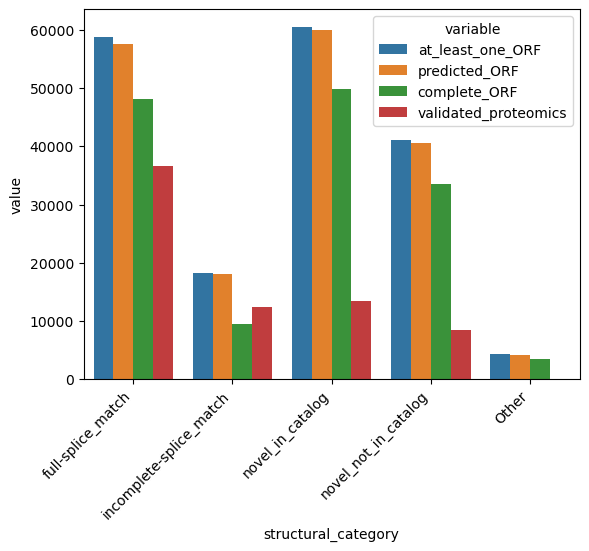

In [19]:
lr_bulk.var = lr_bulk.var\
    .with_columns(
        pl.col("structural_category").cast(pl.String)
    )\
    .with_columns(
        pl.when(pl.col("structural_category").is_in(["novel_not_in_catalog", "novel_in_catalog", "full-splice_match", "incomplete-splice_match"]))\
            .then(pl.col("structural_category"))\
            .otherwise(pl.lit("Other"))
    )
temp = lr_bulk.var\
    .with_columns(
        pl.when(pl.col("ORF_type")=="complete").then(pl.lit(True)).otherwise(pl.lit(False)).alias("complete_ORF")
    ).drop("ORF_type")\
    .group_by("structural_category")\
    .agg(
        at_least_one_ORF = pl.col("at_least_one_orf").sum(),
        predicted_ORF = pl.col("predicted_orf").sum(),
        complete_ORF = pl.col("complete_ORF").sum(),
        validated_proteomics = pl.col("validated_proteomics").sum()
    )\
    .unpivot(index="structural_category")\
    .with_columns(
        pl.col("structural_category").cast(pl.Enum(["full-splice_match", "incomplete-splice_match", "novel_in_catalog", "novel_not_in_catalog", "Other"]))
    )
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
sns.barplot(data=temp.to_pandas(), x="structural_category", y="value", hue="variable", ax =ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

## Lengths don't match in PacBio files

In [ ]:
def compare_sequence_len(fasta_tab_file, gtf_file):
    fasta = pl.read_csv(fasta_tab_file, separator = "\t", has_header=False, new_columns=["pbid", "sequence", "null", "len"])["pbid", "len"]
    fasta = fasta\
        .with_columns(
            pl.col("pbid").str.split("|").map_elements(lambda x: x[0], return_dtype=pl.String)
        )
    gtf = read_gtf(gtf_file)
    gtf_len = gtf\
        .filter(
            pl.col("feature") == "exon"
        )\
        .with_columns(
            diff = pl.col("end") - pl.col("start") + 1
        )\
        .group_by("transcript_id")\
        .agg(
            pl.col("diff").sum()
        )
    return fasta\
        .join(
            gtf_len.rename({"transcript_id": "pbid"}),
            how = "left",
            on = "pbid"
        )

In [11]:
compare_sequence_len("proc/merged_collapsed.fasta.tab", "proc/merged_collapsed.gff")

pbid,len,diff
str,i64,i64
"""PB.1.1""",2810,2809
"""PB.1.2""",1680,1678
"""PB.1.3""",2499,2498
"""PB.1.4""",2113,2111
"""PB.1.5""",3359,3360
…,…,…
"""PB.113109.1""",1831,1837
"""PB.113110.1""",723,726
"""PB.113111.1""",1264,1264


In [50]:
compare_sequence_len("/scratch/s/shreejoy/nxu/SFARI/work/c5/65ddff00571c118620e9321f40211d/transcripts.fasta.tab", "/scratch/s/shreejoy/nxu/SFARI/work/c5/65ddff00571c118620e9321f40211d/merged_collapsed.sorted.filtered_lite.gff")

pbid,len,diff
str,i64,i64
"""PB.6.9""",3984,3984
"""PB.6.8""",2646,2646
"""PB.6.10""",2339,2339
"""PB.6.14""",1898,1898
"""PB.6.2""",1658,1658
…,…,…
"""PB.112873.1193""",4436,4436
"""PB.112873.1196""",3680,3680
"""PB.112873.1199""",2482,2482


In [17]:
TD_genome_gff3 = read_gff("nextflow_results/transcripts_filtered.fasta.transdecoder.genome.gff3", attributes=["ID", "Parent"]).drop_nulls("seqname")\
    .with_columns(
        pl.col("feature").replace({"gene": "gene", "five_prime_UTR": "five_prime_UTR", "exon": "exon", "mRNA": "transcript", "CDS": "CDS", "three_prime_UTR": "three_prime_UTR"})
    )\
    .with_columns(
        pl.when(pl.col("feature")=="gene")\
            .then(pl.col("ID").str.split("^").map_elements(lambda x: x[0], return_dtype=pl.String))\
            .when(pl.col("feature")=="transcript")\
            .then(pl.col("ID").str.extract(r"^(.*)\.p\d+$"))\
            .otherwise(pl.col("ID")),
        pl.when(pl.col("feature")=="transcript")\
            .then(pl.col("Parent").str.extract(r"^(.*)\^chr"))\
            .when(pl.col("feature").is_in(["three_prime_UTR", "five_prime_UTR", "CDS", "exon"]))\
            .then(pl.col("Parent").str.extract(r"^(.*)\.p\d+$"))\
            .otherwise(pl.col("Parent"))
    )\
    .with_columns(
        gene_id = pl.when(pl.col("feature")=="gene")\
        .then(pl.col("ID"))\
        .when(pl.col("feature")=="transcript")\
        .then(pl.col("Parent"))\
        .otherwise(pl.col("Parent").str.split(".").map_elements(lambda x: ".".join([x[0], x[1]]), return_dtype=pl.String)),

        transcript_id = pl.when(pl.col("feature")=="gene")\
        .then(pl.lit(None))\
        .when(pl.col("feature")=="transcript")\
        .then(pl.col("ID"))\
        .otherwise(pl.col("Parent"))
    )

In [32]:
!cat /scratch/s/shreejoy/nxu/SFARI/work/d8/8eea1df17bff6a68d4805cd1a50cce/.command.log




	Done.  180238 / 180238 transcript orfs could be propagated to the genome


scontrol show job 13974842
JobId=13974842 JobName=nf-cdnaAlignmentOrfToGenome
   UserId=nxu(3122125) GroupId=shreejoy(6036412) MCS_label=N/A
   Priority=2324467 Nice=0 Account=rrg-shreejoy QOS=normal
   JobState=COMPLETING Reason=None Dependency=(null)
   Requeue=0 Restarts=0 BatchFlag=1 Reboot=0 ExitCode=0:0
   RunTime=00:09:58 TimeLimit=02:00:00 TimeMin=N/A
   SubmitTime=2024-12-13T03:59:43 EligibleTime=2024-12-13T03:59:43
   AccrueTime=2024-12-13T03:59:43
   StartTime=2024-12-13T03:59:45 EndTime=2024-12-13T04:09:43 Deadline=N/A
   SuspendTime=None SecsPreSuspend=0 LastSchedEval=2024-12-13T03:59:45 Scheduler=Main
   Partition=compute AllocNode:Sid=nia-login05:182720
   ReqNodeList=(null) ExcNodeList=(null)
   NodeList=nia1340
   BatchHost=nia1340
   NumNodes=1 NumCPUs=80 NumTasks=1 CPUs/Task=40 ReqB:S:C:T=0:0:*:*
   ReqTRES=cpu=40,mem=175000M,node=1,billing=20
   AllocTRES=cpu=80,mem=175000M,node=1,billing

In [38]:
TD_genome_gff3

seqname,source,feature,start,end,score,strand,frame,attributes,ID,Parent,gene_id,transcript_id
str,str,str,i64,i64,str,str,str,str,str,str,str,str
"""chr2""","""transdecoder""","""transcript""",32165807,32221735,""".""","""+""",""".""","""ID=PB.10002.1.p2;Parent=PB.100…","""PB.10002.1""","""PB.10002""","""PB.10002""","""PB.10002.1"""
"""chr2""","""transdecoder""","""transcript""",32416097,32524920,""".""","""+""",""".""","""ID=PB.10002.1164.p1;Parent=PB.…","""PB.10002.1164""","""PB.10002""","""PB.10002""","""PB.10002.1164"""
"""chr2""","""transdecoder""","""transcript""",32165834,32222825,""".""","""+""",""".""","""ID=PB.10002.12.p1;Parent=PB.10…","""PB.10002.12""","""PB.10002""","""PB.10002""","""PB.10002.12"""
"""chr2""","""transdecoder""","""transcript""",32436014,32476261,""".""","""+""",""".""","""ID=PB.10002.1258.p1;Parent=PB.…","""PB.10002.1258""","""PB.10002""","""PB.10002""","""PB.10002.1258"""
"""chr2""","""transdecoder""","""transcript""",32453873,32524934,""".""","""+""",""".""","""ID=PB.10002.1401.p1;Parent=PB.…","""PB.10002.1401""","""PB.10002""","""PB.10002""","""PB.10002.1401"""
…,…,…,…,…,…,…,…,…,…,…,…,…
"""chr18""","""transdecoder""","""transcript""",70289012,70327119,""".""","""+""",""".""","""ID=PB.99951.20.p1;Parent=PB.99…","""PB.99951.20""","""PB.99951""","""PB.99951""","""PB.99951.20"""
"""chr18""","""transdecoder""","""transcript""",70288898,70327068,""".""","""+""",""".""","""ID=PB.99951.4.p1;Parent=PB.999…","""PB.99951.4""","""PB.99951""","""PB.99951""","""PB.99951.4"""
"""chr18""","""transdecoder""","""transcript""",70289687,70327117,""".""","""+""",""".""","""ID=PB.99951.43.p1;Parent=PB.99…","""PB.99951.43""","""PB.99951""","""PB.99951""","""PB.99951.43"""


# Annotate lr_bulk

In [34]:
lr_bulk.to_frame().write_parquet("export/pbid_count_matrix.parquet")

In [40]:
lr_bulk.var.write_csv("export/merged_collapsed_classification.filtered_lite_classification.txt", separator="\t")